# PyCUDA_multiplicar_sumar_elementos



## Instalación de la librería

In [1]:
!pip install pycuda

## Importando las librerías

In [121]:
# Para inicializar automáticamente PyCUDA y la GPU
import pycuda.autoinit

# Para interactuar directamente con el controlador de la GPU
import pycuda.driver as drv

# Para manipular arrays y operaciones en la CPU
import numpy as np

# Para compilar y cargar módulos CUDA en la GPU
from pycuda.compiler import SourceModule

# Para medir los tiempos
import time

# Para generar gráficos
import matplotlib.pyplot as plt

## Verificación de los recursos de GPU

In [122]:
drv.init()
print("%d dispositivo(s) encontrado." % drv.Device.count())
for i in range(drv.Device.count()):
  dev = drv.Device(i)
  print("\n Dispositivo #%d: %s" % (i, dev.name()))
  print(" Memoria Total: %s GB" % (dev.total_memory() // (1024 * 1024 * 1024)))
  print(" Capacidad de Computación: %d.%d" % dev.compute_capability())

1 dispositivo(s) encontrado.

 Dispositivo #0: NVIDIA GeForce GTX 1070 with Max-Q Design
 Memoria Total: 7 GB
 Capacidad de Computación: 6.1


## Ejemplo del uso de PyCUDA, multiplicación por número

In [123]:
# Establece la semilla para reproducibilidad
np.random.seed(42)

# Crea una matriz con números aleatorios enteros entre 0 y 10
a = np.random.randint(0, 11, size=(8,8))
# Convierte la matriz a formato de punto flotante de 32 bits
a = a.astype(np.float32)

a

array([[ 6.,  3., 10.,  7.,  4.,  6.,  9.,  2.],
       [ 6., 10., 10.,  7.,  4.,  3.,  7.,  7.],
       [ 2.,  5.,  4.,  1.,  7.,  5.,  1.,  4.],
       [ 0.,  9.,  5.,  8.,  0., 10., 10.,  9.],
       [ 2.,  6.,  3.,  8.,  2.,  4.,  2.,  6.],
       [ 4.,  8.,  6.,  1.,  3.,  8.,  1.,  9.],
       [ 8.,  9.,  4.,  1.,  3.,  6.,  7.,  2.],
       [ 0.,  3.,  1.,  7.,  3.,  1.,  5.,  5.]], dtype=float32)

### GPU

In [124]:

# Asigna memoria en la GPU para la matriz
a_gpu = drv.mem_alloc(a.nbytes)

# Copia los datos de la matriz de la memoria del host a la memoria de la GPU
drv.memcpy_htod(a_gpu, a)

# Define un módulo de código CUDA
mod = SourceModule("""
  __global__ void doublify(float *a)
  {
    //int blockId = (gridDim.x * blockIdx.y) + blockIdx.x;              
    //int idx = (blockId * (blockDim.x * blockDim.y)) + (threadIdx.y * blockDim.x) + threadIdx.x;
    
    int idx= (blockIdx.x * blockDim.x + threadIdx.x) + (blockIdx.y * blockDim.y + threadIdx.y) * 8;               
                   
    //int idx = threadIdx.x + threadIdx.y * blockDim.x;
    
    a[idx] *= 2;
    
    printf("threadIdx.x: %d, threadIdx.y:%d, blockDim.x:%d, blockDim.y :%d idx: %d\\n",threadIdx.x, threadIdx.y, blockDim.x,blockDim.y, idx);               
  }
  """)

# Obtiene la función 'doublify' del módulo CUDA
func = mod.get_function("doublify")

# Inicia el tiempo de medición para la operación CUDA
start_time_cuda = time.time()

# Ejecuta la función 'doublify' en un bloque de 4x4 hilos

func(a_gpu, block=(4,4,1), grid=(2,2))
#func(a_gpu, block=(8,8,1))

# Sincroniza el contexto de CUDA para asegurarse de que todas las operaciones en la GPU se hayan completado
drv.Context.synchronize()

# Crea una matriz vacía con la misma forma y tipo que la matriz 'a'
a_doubled = np.empty_like(a)

# Copia los datos de la matriz procesada desde la memoria de la GPU al host
drv.memcpy_dtoh(a_doubled, a_gpu)

# Detiene el tiempo de medición para la operación CUDA
end_time_cuda = time.time()
# Calcula el tiempo total de la operación CUDA
time_cuda = end_time_cuda - start_time_cuda

print("Tiempo de ejecución CUDA: ", time_cuda)

# Imprime la matriz procesada
print("Matriz procesada:\n")
print(a_doubled)

# Imprime la matriz original
print("Matriz original:\n")
print(a)

threadIdx.x: 0, threadIdx.y:0, blockDim.x:4, blockDim.y :4 idx: 36
threadIdx.x: 1, threadIdx.y:0, blockDim.x:4, blockDim.y :4 idx: 37
threadIdx.x: 2, threadIdx.y:0, blockDim.x:4, blockDim.y :4 idx: 38
threadIdx.x: 3, threadIdx.y:0, blockDim.x:4, blockDim.y :4 idx: 39
threadIdx.x: 0, threadIdx.y:1, blockDim.x:4, blockDim.y :4 idx: 44
threadIdx.x: 1, threadIdx.y:1, blockDim.x:4, blockDim.y :4 idx: 45
threadIdx.x: 2, threadIdx.y:1, blockDim.x:4, blockDim.y :4 idx: 46
threadIdx.x: 3, threadIdx.y:1, blockDim.x:4, blockDim.y :4 idx: 47
threadIdx.x: 0, threadIdx.y:2, blockDim.x:4, blockDim.y :4 idx: 52
threadIdx.x: 1, threadIdx.y:2, blockDim.x:4, blockDim.y :4 idx: 53
threadIdx.x: 2, threadIdx.y:2, blockDim.x:4, blockDim.y :4 idx: 54
threadIdx.x: 3, threadIdx.y:2, blockDim.x:4, blockDim.y :4 idx: 55
threadIdx.x: 0, threadIdx.y:3, blockDim.x:4, blockDim.y :4 idx: 60
threadIdx.x: 1, threadIdx.y:3, blockDim.x:4, blockDim.y :4 idx: 61
threadIdx.x: 2, threadIdx.y:3, blockDim.x:4, blockDim.y :4 idx

### CPU

In [125]:
# Inicia el tiempo de medición para la operación con bucle en cpu
start_time_cpu = time.time()

# Duplica cada elemento de la matriz utilizando un bucle for
a_doubled_python = np.empty_like(a)
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        a_doubled_python[i, j] = a[i, j] * 2

# Detiene el tiempo de medición para la operación con bucle en Python
end_time_cpu = time.time()

# Calcula el tiempo total de la operación con bucle en Python
time_cpu= end_time_cpu - start_time_cpu

print("Tiempo de ejecución cpu: ", time_cpu)


Tiempo de ejecución cpu:  0.0015554428100585938


In [126]:
np.array_equal(a_doubled_python,a_doubled)

True

### Comparación GPU vs CPU

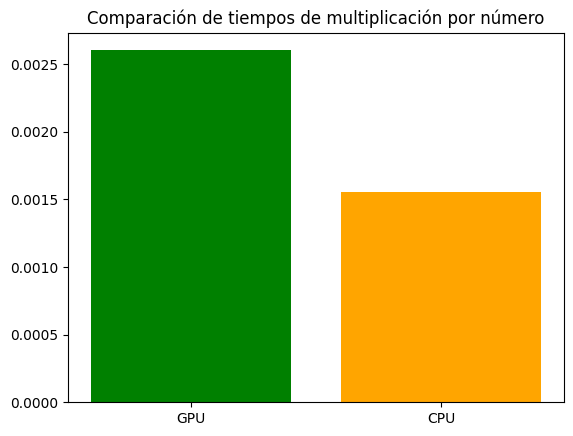

In [127]:
# Nombres de las operaciones
labels = ['GPU', 'CPU']

# Valores de tiempo
values = [time_cuda, time_cpu]

# Graficar en barras con escala logarítmica en el eje y
plt.bar(labels, values, color=['green', 'orange'])
plt.title('Comparación de tiempos de multiplicación por número')
plt.show()


## Suma de matrices

In [129]:
# Establece la semilla para reproducibilidad
np.random.seed(42)

# Crear dos matrices aleatorias
b = np.random.randint(0, 11, size=(128, 128)).astype(np.float32)
c = np.random.randint(0, 11, size=(128, 128)).astype(np.float32)

# Imprime las matrices originales
print("Matriz 'b':")
print(b)
print("\nMatriz 'c':")
print(c)

Matriz 'b':
[[ 6.  3. 10. ...  6.  6. 10.]
 [ 8.  9.  9. ...  0.  1.  0.]
 [ 4.  4. 10. ...  2.  8.  9.]
 ...
 [ 4.  4.  7. ...  9.  5.  6.]
 [ 8.  0.  3. ...  3.  9.  8.]
 [ 3.  3.  6. ...  0.  1.  5.]]

Matriz 'c':
[[ 8.  4.  3. ...  1.  7.  5.]
 [ 6.  0.  5. ...  9.  0.  7.]
 [ 0.  8.  5. ...  5.  0.  1.]
 ...
 [ 0.  1.  3. ...  6.  1.  9.]
 [ 1.  5.  8. ... 10.  1. 10.]
 [ 6.  0.  3. ...  8.  9.  4.]]


### GPU

In [131]:
# Definición del módulo de CUDA que contiene la función del kernel
mod2 = SourceModule("""
  __global__ void add2(float *a, float *b)
  {
    int idx = (blockIdx.x * blockDim.x + threadIdx.x) + (blockIdx.y * blockDim.y + threadIdx.y) * 128;
    a[idx] += b[idx];
  }
  """)

# Asignar memoria en la GPU para las matrices
b_gpu = drv.mem_alloc(b.nbytes)
c_gpu = drv.mem_alloc(c.nbytes)

# Copiar los datos de las matrices al dispositivo (GPU)
drv.memcpy_htod(b_gpu, b)
drv.memcpy_htod(c_gpu, c)

# Obtener la función del kernel compilado
func = mod2.get_function("add2")

# Iniciar el cronómetro
start_time = time.time()

# Llamar a la función del kernel con las matrices como argumentos
func(b_gpu, c_gpu, block=(32,32,1), grid=(4,4))

# Crear un array vacío del mismo tamaño que b para almacenar el resultado
added = np.empty_like(b)

# Copiar los resultados desde la memoria de la GPU al array creado
drv.memcpy_dtoh(added, b_gpu)

# Parar el cronómetro
end_time = time.time()

# Calcular la duración
duration1 = end_time - start_time

# Imprimir los resultados
print("Matriz B:\n")
print(b)
print("Matriz C:\n")
print(c)
print("Resultado suma:\n")
print(added)

# Imprimir el tiempo de ejecución
print("Tiempo de ejecución: {:.6f} segundos".format(duration1))

Matriz B:

[[ 6.  3. 10. ...  6.  6. 10.]
 [ 8.  9.  9. ...  0.  1.  0.]
 [ 4.  4. 10. ...  2.  8.  9.]
 ...
 [ 4.  4.  7. ...  9.  5.  6.]
 [ 8.  0.  3. ...  3.  9.  8.]
 [ 3.  3.  6. ...  0.  1.  5.]]
Matriz C:

[[ 8.  4.  3. ...  1.  7.  5.]
 [ 6.  0.  5. ...  9.  0.  7.]
 [ 0.  8.  5. ...  5.  0.  1.]
 ...
 [ 0.  1.  3. ...  6.  1.  9.]
 [ 1.  5.  8. ... 10.  1. 10.]
 [ 6.  0.  3. ...  8.  9.  4.]]
Resultado suma:

[[14.  7. 13. ...  7. 13. 15.]
 [14.  9. 14. ...  9.  1.  7.]
 [ 4. 12. 15. ...  7.  8. 10.]
 ...
 [ 4.  5. 10. ... 15.  6. 15.]
 [ 9.  5. 11. ... 13. 10. 18.]
 [ 9.  3.  9. ...  8. 10.  9.]]
Tiempo de ejecución: 0.000581 segundos


### CPU

In [132]:
# Iniciar el cronómetro
start_time = time.time()

# Crear un array vacío del mismo tamaño que b para almacenar el resultado
addedCPU = np.empty_like(b)

# Realizar la suma elemento a elemento
for i in range(b.shape[0]):
    for j in range(b.shape[1]):
        addedCPU[i, j] = b[i, j] + c[i, j]

# Parar el cronómetro
end_time = time.time()

# Calcular la duración
duration2 = end_time - start_time

# Imprimir los resultados
print("Matriz B:\n", b)
print("Matriz C:\n", c)
print("Resultado suma:\n", addedCPU)

# Imprimir el tiempo de ejecución
print("Tiempo de ejecución en CPU: {:.6f} segundos".format(duration2))

Matriz B:
 [[ 6.  3. 10. ...  6.  6. 10.]
 [ 8.  9.  9. ...  0.  1.  0.]
 [ 4.  4. 10. ...  2.  8.  9.]
 ...
 [ 4.  4.  7. ...  9.  5.  6.]
 [ 8.  0.  3. ...  3.  9.  8.]
 [ 3.  3.  6. ...  0.  1.  5.]]
Matriz C:
 [[ 8.  4.  3. ...  1.  7.  5.]
 [ 6.  0.  5. ...  9.  0.  7.]
 [ 0.  8.  5. ...  5.  0.  1.]
 ...
 [ 0.  1.  3. ...  6.  1.  9.]
 [ 1.  5.  8. ... 10.  1. 10.]
 [ 6.  0.  3. ...  8.  9.  4.]]
Resultado suma:
 [[14.  7. 13. ...  7. 13. 15.]
 [14.  9. 14. ...  9.  1.  7.]
 [ 4. 12. 15. ...  7.  8. 10.]
 ...
 [ 4.  5. 10. ... 15.  6. 15.]
 [ 9.  5. 11. ... 13. 10. 18.]
 [ 9.  3.  9. ...  8. 10.  9.]]
Tiempo de ejecución en CPU: 0.013484 segundos


In [133]:
np.array_equal(added,addedCPU)

True

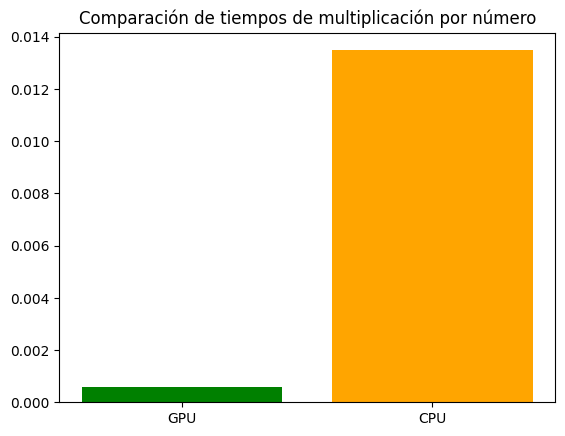

In [134]:
# Nombres de las operaciones
labels = ['GPU', 'CPU']

# Valores de tiempo
values = [duration1, duration2]

# Graficar en barras con escala logarítmica en el eje y
plt.bar(labels, values, color=['green', 'orange'])
plt.title('Comparación de tiempos de multiplicación por número')
plt.show()


In [30]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# Define el código del kernel de CUDA
kernel_code = """
__global__ void print_kernel()
{
    printf("Hello from block %d, thread %d\\n", blockIdx.x, threadIdx.x);
}
"""

# Compila el kernel
mod = SourceModule(kernel_code)

# Obtiene la función del kernel
print_kernel = mod.get_function("print_kernel")

# Lanza el kernel
print_kernel(block=(1, 1, 1), grid=(1, 1))

# Sincroniza para asegurar que se completa la ejecución del kernel
cuda.Context.synchronize()


Hello from block 0, thread 0
